In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
# Libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
import re 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import numpy as np

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Data Loading
2. Data cleaning 
3. Data preprocessing
4. EDA 
5. Embedding Representation
6. Model Building

# Data Loading

In [3]:
df_test = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv")
df_train = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin-1')

# Data Cleaning

In [4]:
#Checking for NULL VALUES
df_train.isnull().sum()
df_test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [5]:
df_test

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [6]:
#Dropping for NULL VALUES
df_train = df_train.drop('Location',axis = 1)
df_test = df_test.drop('Location',axis = 1)


In [7]:
#Checking for Duplicated Values
df_train.duplicated().sum()
df_test.duplicated().sum()

0

In [8]:
#Selecting Independent Variable 
X = df_train[['OriginalTweet']]
x = df_test[['OriginalTweet']]

In [9]:
#Selecting Dependent Variable 
Y = df_train[['Sentiment']]
y = df_test[['Sentiment']]

In [10]:
X = X.rename(columns ={"OriginalTweet":"Tweets"})
x = x.rename(columns ={"OriginalTweet":"Tweets"})

# Data preprocessing

In [11]:
Y = Y.replace("Extremely Negative","Negative")
Y = Y.replace("Extremely Positive","Positive")
y = y.replace("Extremely Negative","Negative")
y = y.replace("Extremely Positive","Positive")

In [12]:
labelencoder = LabelEncoder()

Y['Label'] = labelencoder.fit_transform(Y['Sentiment'])
y['Label'] = labelencoder.transform(y['Sentiment'])

In [13]:
Y = Y.drop('Sentiment',axis = 1)
y = y.drop('Sentiment',axis = 1)

y {
    Neutral : 1
    Positive: 2
    Negative: 0
}
Y {
    Neutral : 1
    Positive: 2
    Negative: 0
}

In [14]:
def clean_text(txt):
    ps = PorterStemmer()
    Corpus = []

    for i in range(0,len(txt)):
       #removing all the URLs
        review = re.sub(r'http\S+',' ',txt['Tweets'][i])
    #remove html tags
        review = re.sub(r'<.*?>',' ', review) 
    #remove digits
        review = re.sub(r'\d+',' ', review)
    #remove hashtags
        review = re.sub(r'#\w+',' ', review)
        review = re.sub('[^a-zA-Z]',' ',review)
        review = review.lower()
        review = review.split()
    
        review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        Corpus.append(review)
    return Corpus

In [15]:
X['Clean_text'] = clean_text(X)
x['Clean_text'] = clean_text(x)

# Exploratory Data Analysis

<AxesSubplot:xlabel='Label', ylabel='count'>

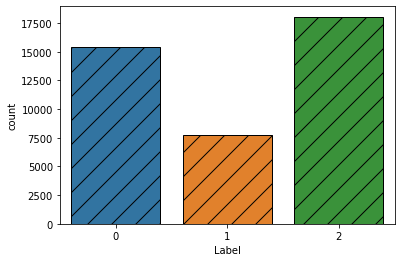

In [16]:
sn.countplot(x = 'Label', data = Y,lw = 1, ec = 'black', hatch = '/')

There are 4115738 words in the combination of all cells in column Clean_text.


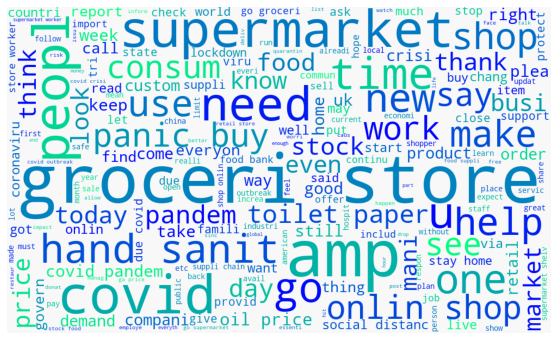

In [17]:
#Generating a Wordcould out of our Clean_Text
text = " ".join(review for review in X.Clean_text.astype(str))
print ("There are {} words in the combination of all cells in column Clean_text.".format(len(text)))
stopwords = set(STOPWORDS)
plt.figure(figsize=(10, 6))
wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap='winter')
wc.generate(text)
plt.imshow(wc)
plt.axis("off")
plt.show()

In [18]:
voc_size = 31759
X_train = [one_hot(words, voc_size)for words in X.Clean_text]
X_test = [one_hot(words, voc_size)for words in x.Clean_text]

In [19]:
X_train = pad_sequences(X_train, padding = 'post', maxlen = 30)
X_test = pad_sequences(X_test, padding = 'post', maxlen = 30)

In [20]:
#creating model
embedding_vector_feature = 16
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_feature,input_length = 289))
model.add(LSTM(500))
model.add(Dense(3,activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

2022-08-13 11:42:48.886090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 11:42:48.998141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 11:42:48.998963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 11:42:49.000141: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 289, 16)           508144    
_________________________________________________________________
lstm (LSTM)                  (None, 500)               1034000   
_________________________________________________________________
dense (Dense)                (None, 3)                 1503      
Total params: 1,543,647
Trainable params: 1,543,647
Non-trainable params: 0
_________________________________________________________________
None


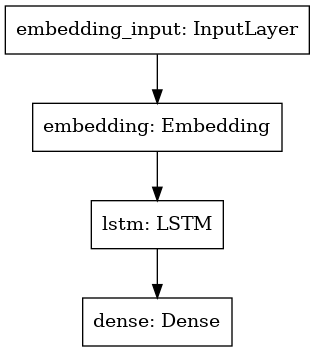

In [21]:
tf.keras.utils.plot_model(model)

In [22]:
X_train = np.array(X_train)
y_train = np.array(Y)
X_test = np.array(X_test)
y_test = np.array(y)

In [23]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((41157, 30), (41157, 1), (3798, 30), (3798, 1))

In [24]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [25]:
y_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [26]:
model = model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 7,batch_size = 64)

2022-08-13 11:42:53.349414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7


2022-08-13 11:42:55.668315: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


644/644 [==============================] - 10s 9ms/step - loss: 0.8927 - accuracy: 0.5296 - val_loss: 0.7381 - val_accuracy: 0.6909
Epoch 2/7
644/644 [==============================] - 6s 9ms/step - loss: 0.6277 - accuracy: 0.7507 - val_loss: 0.6615 - val_accuracy: 0.7351
Epoch 3/7
644/644 [==============================] - 5s 8ms/step - loss: 0.5635 - accuracy: 0.7892 - val_loss: 0.6658 - val_accuracy: 0.7475
Epoch 4/7
644/644 [==============================] - 6s 9ms/step - loss: 0.5088 - accuracy: 0.8168 - val_loss: 0.6576 - val_accuracy: 0.7522
Epoch 5/7
644/644 [==============================] - 5s 8ms/step - loss: 0.4151 - accuracy: 0.8558 - val_loss: 0.6063 - val_accuracy: 0.7741
Epoch 6/7
644/644 [==============================] - 6s 9ms/step - loss: 0.3266 - accuracy: 0.8911 - val_loss: 0.6026 - val_accuracy: 0.7844
Epoch 7/7
644/644 [==============================] - 5s 8ms/step - loss: 0.2667 - accuracy: 0.9129 - val_loss: 0.6533 - val_accuracy: 0.7773


# Adding Dropout

In [27]:
y_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [28]:
model = Sequential()
model.add(Embedding(voc_size,40,input_length = 289))
model.add(Dropout(0.3))
model.add(LSTM(500))
model.add(Dropout(0.3))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss='category_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [29]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
y_test = np.argmax(y_test,axis = 1)
confusion_matrix(y_test,classes_x)

array([[  16,   13, 1604],
       [   2,    3,  614],
       [  14,   21, 1511]])